In [1]:
import os, sys
sys.path.append('..')
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import json

from sklearn.manifold import TSNE
from skimage.io import imread, imsave

from datasets import dataset as dataset
from models.nn import ResNet_18 as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

from models.utils import grad_cam, get_feature_maps

from datasets.utils import view_image_cam_pairs

In [2]:
image_save_dir = './images'

In [3]:
""" Load dataset """
root_dir = ('/Data/emnist/balanced/original') # FIXME

In [4]:
anno_path = os.path.join(root_dir, 'annotation', 'annotation1.json')
with open(anno_path, 'r') as fid:
    anno_dict = json.load(fid)
cls_list = anno_dict['classes'].values()
print(cls_list)

dict_values(['P', 'Z', '8', 'B', 'S', 'e', 'a', 'K', 'Y', 'M', 'Q', 'W', 'L', 'F', 'A', 'J', 'f', 'g', 'O', 'V', 'X', '2', 'D', 'H', 'b', 'U', 'r', 'I', 'N', 'h', '9', '6', '3', 't', 'n', '0', 'R', '7', 'C', '5', 'G', 'T', 'E', '4', '1', 'q', 'd'])


In [5]:
for i in range(len(anno_dict['classes'])):
    print(i, anno_dict['classes'][str(i)])

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 A
11 B
12 C
13 D
14 E
15 F
16 G
17 H
18 I
19 J
20 K
21 L
22 M
23 N
24 O
25 P
26 Q
27 R
28 S
29 T
30 U
31 V
32 W
33 X
34 Y
35 Z
36 a
37 b
38 d
39 e
40 f
41 g
42 h
43 n
44 q
45 r
46 t


In [6]:
imset_path = os.path.join(root_dir, 'imageset','imageset1')

file_list = []
for txt in ['train1.txt','validation1.txt','test.txt']:
    with open(os.path.join(imset_path,txt)) as fid:
        tmp = fid.read().split('\n')[:-1]
        file_list += tmp

print('모든 데이터셋 크기:',len(file_list))

모든 데이터셋 크기: 131598


8 : 2800
r : 2799
P : 2800
R : 2800
X : 2800
E : 2800
e : 2800
L : 2800
J : 2800
Q : 2800
Y : 2800
A : 2800
O : 2800
9 : 2800
T : 2800
W : 2800
t : 2800
b : 2800
h : 2800
F : 2800
5 : 2800
I : 2800
2 : 2800
M : 2800
g : 2799
1 : 2800
q : 2800
K : 2800
a : 2800
N : 2800
f : 2800
G : 2800
S : 2800
6 : 2800
3 : 2800
Z : 2800
V : 2800
0 : 2800
C : 2800
7 : 2800
n : 2800
H : 2800
B : 2800
4 : 2800
U : 2800
d : 2800
D : 2800


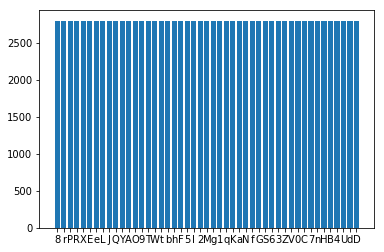

In [7]:
dic = {cls:[] for cls in cls_list}

for file in file_list:
    cls = file.split('_')[1]
    dic[cls].append(file)

y =[]
x = []
for cls in dic.keys():
    print(cls,':',len(dic[cls]))
    x.append(cls); y.append(len(dic[cls]))

plt.bar(range(len(x)),y, tick_label=x)
plt.savefig(os.path.join(image_save_dir,'class_bar.png'))
plt.show()

In [8]:
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Load results from pickle file
#with open('../output/cv_emnist_resnet_test_result.pkl', 'rb') as fid:
with open('../output/fold1_noisy_emnist_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)

In [9]:
test_score_per_train_portion = dict()
for fold_idx in test_result_dict.keys():
    for portion in test_result_dict[fold_idx].keys():
        if portion not in test_score_per_train_portion:
            test_score_per_train_portion[portion] = []
        test_score_per_train_portion[portion].append(test_result_dict[fold_idx][portion])
# test_score_per_train_portion
# >> {1.0: [result1 by fold1, result2 by fold2, ...], 0.75: [resutl1 by fold1, ...], ...}

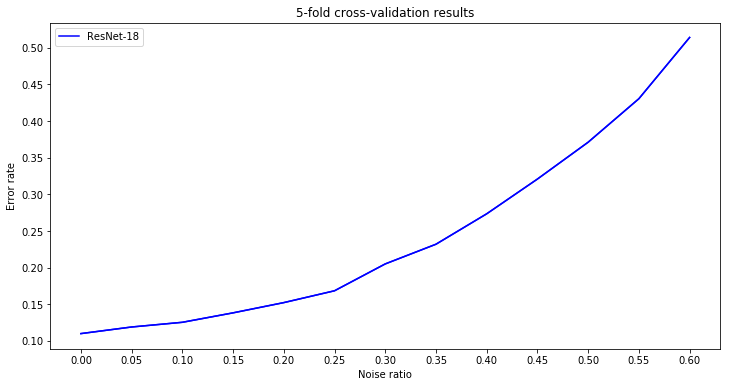

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = [v*1 for v in sorted(test_score_per_train_portion.keys())]
y_mean = [np.mean(l) for k, l in sorted(test_score_per_train_portion.items())]
y_std = [np.std(l) for k, l in sorted(test_score_per_train_portion.items())]
_ = ax.plot(x, y_mean, color='b', label='ResNet-18')
_ = ax.errorbar(x, y_mean, yerr=y_std, color='b')
_ = ax.set_title('5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Noise ratio')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig(os.path.join(image_save_dir, 'cross_validation_results.png'), bbox_inches='tight')
plt.show()

# >> output: accuracy graph averaged over 5 folds

In [11]:
def foldswap(test_result_dict):
    # swap fold and hyperparameter
    test_score = dict()
    for fold_idx in test_result_dict.keys():
        for hp in test_result_dict[fold_idx].keys():
            if hp not in test_score:
                test_score[hp] = []
            test_score[hp].append(test_result_dict[fold_idx][hp])
    # test_score
    # >> {1.0: [result1 by fold1, result2 by fold2, ...], 0.75: [resutl1 by fold1, ...], ...}
    return test_score

def drawline(ax, test_score, linecolor='b', linelabel='1'):
    # mean, std over 5 fold and draw a line
    y_mean = [np.mean(l) for k, l in sorted(test_score.items())]
    y_std = [np.std(l) for k, l in sorted(test_score.items())]
    _ = ax.plot(x, y_mean, color=linecolor, label=linelabel)
    _ = ax.errorbar(x, y_mean, yerr=y_std, color=linecolor)


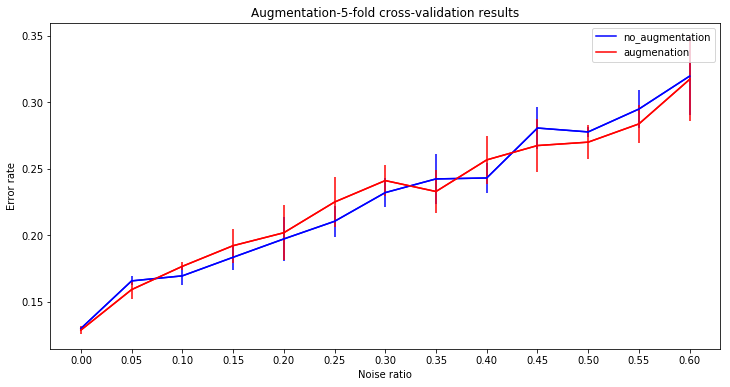

In [22]:
# augmentation comparison
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

test_results = []
# Load results from pickle file
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.0_noaugmentation_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.0_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)    

test_scores = []
for test_result in test_results:
    test_score = foldswap(test_result)
    test_scores.append(test_score)
    
# Plot a graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = sorted(test_scores[0].keys())
# draw a line
drawline(ax, test_scores[0], linecolor='b', linelabel='no_augmentation')
drawline(ax, test_scores[1], linecolor='r', linelabel='augmenation')
_ = ax.set_title('Augmentation-5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Noise ratio')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig(os.path.join(image_save_dir, 'augmenation_cross_validation_results.png'), bbox_inches='tight')
plt.show()

# >> output: accuracy graph averaged over 5 folds

0.180743112035


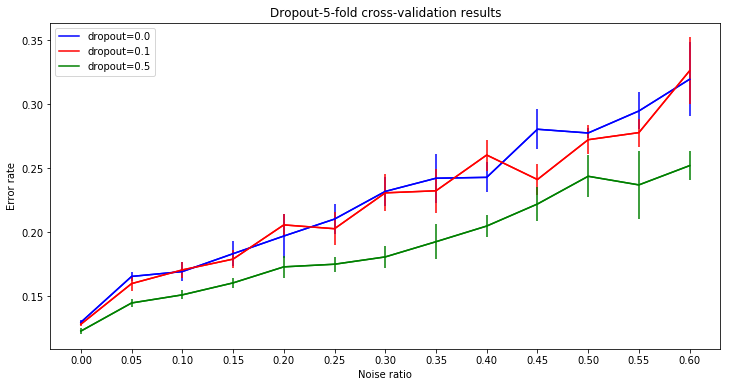

In [34]:
# dropout comparison
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

test_results = []
# Load results from pickle file
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.0_noaugmentation_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.1_noaugmentation_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.5_noaugmentation_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)

test_scores = []
for test_result in test_results:
    test_score = foldswap(test_result)
    test_scores.append(test_score)

print(np.mean(test_scores[2][0.3]))
    
# Plot a graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = sorted(test_scores[0].keys())
# draw a line
drawline(ax, test_scores[0], linecolor='b', linelabel='dropout=0.0')
drawline(ax, test_scores[1], linecolor='r', linelabel='dropout=0.1')
drawline(ax, test_scores[2], linecolor='g', linelabel='dropout=0.5')
_ = ax.set_title('Dropout-5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Noise ratio')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig(os.path.join(image_save_dir, 'dropout_cross_validation_results.png'), bbox_inches='tight')
plt.show()

# >> output: accuracy graph averaged over 5 folds

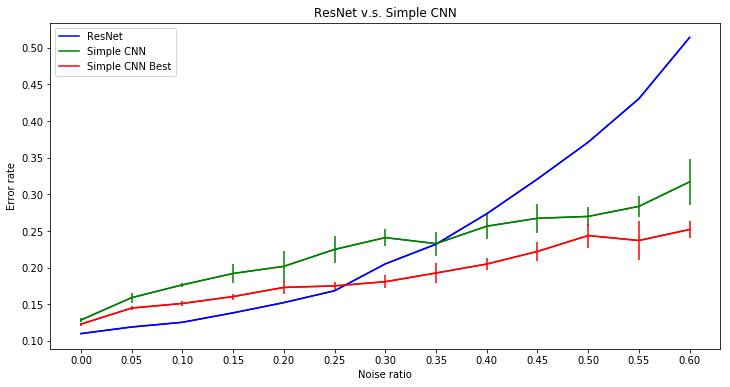

In [29]:
# resnet vs simple CNN network
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

test_results = []
# Load results from pickle file
with open('/Data/github/interview/save/crossvalidation/fold1_noisy_emnist_resnet_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.0_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/cv_emnist_dropout_0.5_noaugmentation_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)

test_scores = []
for test_result in test_results:
    test_score = foldswap(test_result)
    test_scores.append(test_score)
    
# Plot a graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = sorted(test_scores[0].keys())
# draw a line
drawline(ax, test_scores[0], linecolor='b', linelabel='ResNet')
drawline(ax, test_scores[1], linecolor='g', linelabel='Simple CNN')
drawline(ax, test_scores[2], linecolor='r', linelabel='Simple CNN Best')
_ = ax.set_title('ResNet v.s. Simple CNN')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Noise ratio')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig(os.path.join(image_save_dir, 'architecture_compare.png'), bbox_inches='tight')
plt.show()

# >> output: accuracy graph averaged over 5 folds

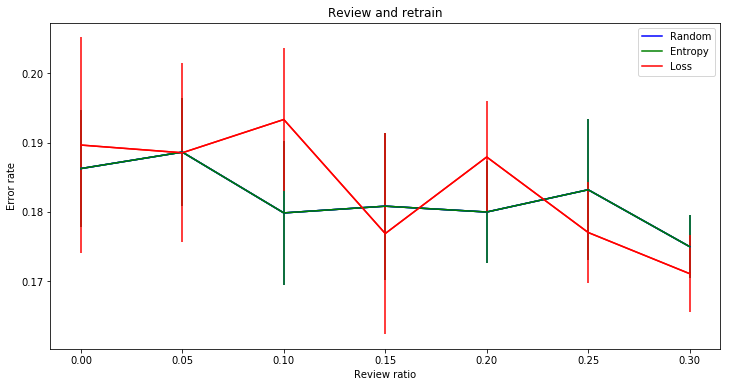

In [38]:
# retraining with recovered annotations (loss vs entropy vs random)
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

test_results = []
# Load results from pickle file
with open('/Data/github/interview/save/crossvalidation/recover0.3/cv_emnist_random_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/recover0.3/cv_emnist_random_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
with open('/Data/github/interview/save/crossvalidation/recover0.3/cv_emnist_loss_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
    test_results.append(test_result_dict)
    
# >>> dropout 0.3으로 해서 잘 안 되었음.
# >>> dropout 0.5로 다시 하는중

test_scores = []
for test_result in test_results:
    test_score = foldswap(test_result)
    test_scores.append(test_score)
    
# Plot a graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = sorted(test_scores[0].keys())
# draw a line
drawline(ax, test_scores[0], linecolor='b', linelabel='Random')
drawline(ax, test_scores[1], linecolor='g', linelabel='Entropy')
drawline(ax, test_scores[2], linecolor='r', linelabel='Loss')
_ = ax.set_title('Review and retrain')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Review ratio')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig(os.path.join(image_save_dir, 'review_retrain.png'), bbox_inches='tight')
plt.show()

# >> output: accuracy graph averaged over 5 folds